In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [2]:
datadir = 'input/'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [3]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [4]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [5]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [6]:
Xtrain = hstack((Xtr_brand, Xtr_model), format='csr')
Xtest =  hstack((Xte_brand, Xte_model), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 1798), test shape (112071, 1798)


In [7]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [8]:
def score(clf, random_state = 667):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #return log_loss(yte, pred[itest, :])
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    #print('')
    print("{:.5f}".format(log_loss(y, pred)), end=' ')
    return log_loss(y, pred)

[  1.00000000e-05   3.59381366e-05   1.29154967e-04   4.64158883e-04
   1.66810054e-03   5.99484250e-03   2.15443469e-02   7.74263683e-02
   2.78255940e-01   1.00000000e+00]
2.42752 2.42666 2.42398 2.41751 2.40801 2.40003 2.39438 2.39094 2.39218 2.40377 

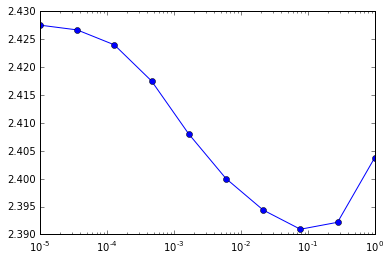

In [9]:
Cs = np.logspace(-5,0,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, multi_class='multinomial',solver='lbfgs')))
plt.semilogx(Cs, res,'-o');

2.39176 2.39117 2.39085 2.39069 2.39064 2.39066 2.39074 2.39085 2.39100 2.39116 

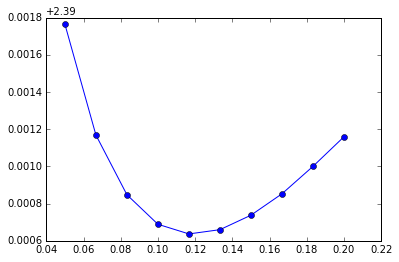

In [11]:
Cs = np.linspace(0.05,0.2,10)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, multi_class='multinomial',solver='lbfgs')))
plt.plot(Cs, res,'-o');

In [12]:
np.linspace(0.05,0.2,10)

array([ 0.05      ,  0.06666667,  0.08333333,  0.1       ,  0.11666667,
        0.13333333,  0.15      ,  0.16666667,  0.18333333,  0.2       ])

In [13]:
score(LogisticRegression(C=0.11666667, multi_class='multinomial',solver='lbfgs',class_weight='balanced'))

2.44623 

2.4462276274420787

In [14]:
def score1(clf, random_state = 22):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #return log_loss(yte, pred[itest, :])
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    #print('')
    print("{:.5f}".format(log_loss(y, pred)), end=' ')
    return log_loss(y, pred)

In [16]:
score1(LogisticRegression(C=0.11666667, multi_class='multinomial',solver='lbfgs'))

2.39071 

2.3907051908423744